In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2  
import time
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2B0, NASNetLarge, Xception, ResNet50    
from tensorflow.keras.models import load_model


print("All libraries imported successfully!")

All libraries imported successfully!


Load Dataset

In [4]:
dataset_path = "/Users/vigneshs/Desktop/Neem_leaf_project/new_neem_dataset"

# Verify dataset directory and classes
classes = os.listdir(dataset_path)
print("Classes found:", classes)

# Check number of images per class
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"Class {class_name}: {num_images} images")

# Load dataset using tf.keras.preprocessing
image_size = (224, 224)  # Standard input size for models
batch_size = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",  # For multi-class classification
    shuffle=True
)

# Print dataset info
print("Dataset loaded successfully.")

Classes found: ['Alternaria', 'Leaf_Miners', '.DS_Store', 'Powdery_Mildew', 'Healthy', 'Dieback', 'Leaf_Blight', 'augmented', 'Leaf_Rust']
Class Alternaria: 1327 images
Class Leaf_Miners: 1734 images
Class Powdery_Mildew: 2671 images
Class Healthy: 3141 images
Class Dieback: 1204 images
Class Leaf_Blight: 2326 images
Class augmented: 7 images
Class Leaf_Rust: 1232 images
Found 68424 files belonging to 8 classes.
Dataset loaded successfully.


Split dataset

In [7]:
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

# Define constants
BASE_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project/new_neem_dataset"
OUTPUT_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project"
CLASS_NAMES = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load dataset into DataFrame
data = []
for class_name in CLASS_NAMES:
    class_dir = os.path.join(BASE_DIR, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Class directory {class_dir} not found. Ensure new_neem_dataset is complete.")
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        if os.path.isfile(img_path):
            data.append({'filename': img_path, 'class': class_name})

df = pd.DataFrame(data)
print(f"Total images: {len(df)}")

# Split dataset (stratified)
train_df, temp_df = train_test_split(
    df,
    test_size=(VAL_SPLIT + TEST_SPLIT),
    stratify=df['class'],
    random_state=42
)

val_size = VAL_SPLIT / (VAL_SPLIT + TEST_SPLIT)
val_df, test_df = train_test_split(
    temp_df,
    test_size=(1 - val_size),
    stratify=temp_df['class'],
    random_state=42
)

# Save splits
train_df_path = os.path.join(OUTPUT_DIR, "train_df.csv")
val_df_path = os.path.join(OUTPUT_DIR, "val_df.csv")
test_df_path = os.path.join(OUTPUT_DIR, "test_df.csv")

train_df.to_csv(train_df_path, index=False)
val_df.to_csv(val_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

# Print split sizes and class distributions
print(f"\nTrain set: {len(train_df)} images")
print("Train class distribution:")
print(train_df['class'].value_counts())

print(f"\nValidation set: {len(val_df)} images")
print("Validation class distribution:")
print(val_df['class'].value_counts())

print(f"\nTest set: {len(test_df)} images")
print("Test class distribution:")
print(test_df['class'].value_counts())

print(f"\nSplits saved to:")
print(f"Train: {train_df_path}")
print(f"Validation: {val_df_path}")
print(f"Test: {test_df_path}")

# Create TensorFlow datasets
def load_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize to [0,1]
    return image, label

# Convert class names to indices
class_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}

# Train dataset
train_labels = tf.keras.utils.to_categorical(
    [class_to_index[c] for c in train_df['class']],
    num_classes=NUM_CLASSES
)
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['filename'].values, train_labels))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(1000, seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_labels = tf.keras.utils.to_categorical(
    [class_to_index[c] for c in val_df['class']],
    num_classes=NUM_CLASSES
)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['filename'].values, val_labels))
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_labels = tf.keras.utils.to_categorical(
    [class_to_index[c] for c in test_df['class']],
    num_classes=NUM_CLASSES
)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['filename'].values, test_labels))
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify dataset sizes
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

print(f"\nTensorFlow Dataset Sizes:")
print(f"Training set: {train_size} images (~{train_size // BATCH_SIZE} batches)")
print(f"Validation set: {val_size} images (~{val_size // BATCH_SIZE} batches)")
print(f"Test set: {test_size} images (~{test_size // BATCH_SIZE} batches)")

# Verify one batch
for images, labels in train_dataset.take(1):
    print(f"\nTrain batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
for images, labels in val_dataset.take(1):
    print(f"Validation batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
for images, labels in test_dataset.take(1):
    print(f"Test batch - Images shape: {images.shape}, Labels shape: {labels.shape}")

print("Dataset splits and TensorFlow datasets created successfully!")

Total images: 13635

Train set: 9544 images
Train class distribution:
class
Healthy           2198
Powdery_Mildew    1870
Leaf_Blight       1628
Leaf_Miners       1214
Alternaria         929
Leaf_Rust          862
Dieback            843
Name: count, dtype: int64

Validation set: 2045 images
Validation class distribution:
class
Healthy           471
Powdery_Mildew    400
Leaf_Blight       349
Leaf_Miners       260
Alternaria        199
Leaf_Rust         185
Dieback           181
Name: count, dtype: int64

Test set: 2046 images
Test class distribution:
class
Healthy           472
Powdery_Mildew    401
Leaf_Blight       349
Leaf_Miners       260
Alternaria        199
Leaf_Rust         185
Dieback           180
Name: count, dtype: int64

Splits saved to:
Train: /Users/vigneshs/Desktop/Neem_leaf_project/train_df.csv
Validation: /Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv
Test: /Users/vigneshs/Desktop/Neem_leaf_project/test_df.csv

TensorFlow Dataset Sizes:
Training set: 9544 images

2025-06-02 22:09:50.426863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-02 22:09:50.525562: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-02 22:09:50.562832: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

Preprocess data for each set

In [5]:
# Define preprocessing function for ResNet50, Xception, and EfficientNetV2B0
def preprocess_data(image, label):
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image, label

# Apply preprocessing to train, validation, and test datasets
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

# Verify preprocessing by checking a sample
for images, labels in train_dataset.take(1):
    print("Sample image shape:", images.shape)
    print("Sample image min value:", tf.reduce_min(images).numpy())
    print("Sample image max value:", tf.reduce_max(images).numpy())
    print("Sample label shape:", labels.shape)

2025-04-13 22:02:07.671803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 577 of 1000
2025-04-13 22:02:17.802596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-04-13 22:02:17.807909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1 of 1000
2025-04-13 22:02:37.612472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 461 of 1000
2025-04-13 22:02:47.630498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 661 of 1000
2025-04-13 22:02:59.310815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 775 of 1000
2025-04-13 22:03:10.527230: I tensorflow/cor

Sample image shape: (32, 224, 224, 3)


2025-04-13 22:03:12.945047: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Sample image min value: 0.0
Sample image max value: 1.0
Sample label shape: (32, 8)


2025-04-13 22:03:14.331065: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Data augmentation (train set only)

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
BASE_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project/new_neem_dataset"
CLASS_NAMES = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
AUGMENTED_DIR = os.path.join(BASE_DIR, "augmented")
os.makedirs(AUGMENTED_DIR, exist_ok=True)

# Define augmentation techniques
augmentations = {
    'rotation': ImageDataGenerator(rotation_range=20, fill_mode='nearest'),
    'width_shift': ImageDataGenerator(width_shift_range=0.2, fill_mode='nearest'),
    'height_shift': ImageDataGenerator(height_shift_range=0.2, fill_mode='nearest'),
    'shear': ImageDataGenerator(shear_range=0.2, fill_mode='nearest'),
    'zoom': ImageDataGenerator(zoom_range=0.2, fill_mode='nearest'),
    'horizontal_flip': ImageDataGenerator(horizontal_flip=True),
    'brightness': ImageDataGenerator(brightness_range=[0.8, 1.2]),
    'contrast': ImageDataGenerator(
        preprocessing_function=lambda x: tf.image.random_contrast(x, 0.8, 1.2)
    ),
    'gaussian_noise': ImageDataGenerator(
        preprocessing_function=lambda x: x + np.random.normal(0, 0.05, x.shape).astype(np.float32)
    ),
    'random_crop': ImageDataGenerator(
        preprocessing_function=lambda x: tf.image.resize(
            tf.image.random_crop(x, [int(224*0.9), int(224*0.9), 3]), 
            [224, 224]
        ).numpy()
    )
}

# Load dataset paths and labels
image_paths = []
labels = []

for class_name in CLASS_NAMES:
    folder_path = os.path.join(BASE_DIR, class_name)
    image_files = [
        os.path.join(folder_path, f) for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    image_paths.extend(image_files)
    labels.extend([class_name] * len(image_files))

# Create DataFrame
df = pd.DataFrame({'filename': image_paths, 'class': labels})

# Use train_dataset to get training indices (from Step 4: 9,532 images)
train_size = 9532
train_paths = []
train_labels = []

# Rebuild train DataFrame matching 9,532 images
for class_name in CLASS_NAMES:
    class_df = df[df['class'] == class_name]
    class_count = len(class_df)
    train_count = int((9532 / len(df)) * class_count)  # Approximate split
    train_paths.extend(class_df['filename'].iloc[:train_count].tolist())
    train_labels.extend([class_name] * train_count)

train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})

# Analyze class distribution
class_counts = train_df['class'].value_counts()
print("Original class distribution in train_df:")
print(class_counts)

# Target number of images per class (match Healthy: 2,196)
target_count = 2196
print(f"Target images per class: {target_count}")

# Initialize counters
augmented_paths = []
augmented_labels = []
augmented_counts = {class_name: {tech: 0 for tech in augmentations.keys()} for class_name in CLASS_NAMES}

# Augment images
for class_name in CLASS_NAMES:
    class_dir = os.path.join(AUGMENTED_DIR, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    class_df = train_df[train_df['class'] == class_name]
    current_count = len(class_df)
    images_needed = target_count - current_count
    
    if images_needed <= 0:
        print(f"No augmentation needed for {class_name} (already {current_count} images)")
        augmented_paths.extend(class_df['filename'].tolist())
        augmented_labels.extend([class_name] * current_count)
        continue
    
    print(f"Augmenting {class_name}: need {images_needed} images")
    techniques = list(augmentations.keys())
    images_per_tech = images_needed // len(techniques)
    remainder = images_needed % len(techniques)
    
    for tech_idx, tech_name in enumerate(techniques):
        count = images_per_tech + (1 if tech_idx < remainder else 0)
        if count == 0:
            continue
            
        class_images = [img_to_array(load_img(img, target_size=IMG_SIZE)) for img in class_df['filename']]
        class_images = np.array(class_images)
        
        datagen = augmentations[tech_name]
        iterator = datagen.flow(
            class_images,
            batch_size=1,
            save_to_dir=class_dir,
            save_prefix=f"{class_name}_{tech_name}",
            save_format='jpg'
        )
        
        for i in range(count):
            aug_img = next(iterator)[0].astype('uint8')
            aug_filename = f"{class_name}_{tech_name}_{i}.jpg"
            aug_path = os.path.join(class_dir, aug_filename)
            save_img(aug_path, aug_img)
            augmented_paths.append(aug_path)
            augmented_labels.append(class_name)
            augmented_counts[class_name][tech_name] += 1
    
    # Copy original images
    for orig_img in class_df['filename']:
        orig_filename = os.path.basename(orig_img)
        new_path = os.path.join(class_dir, orig_filename)
        tf.io.write_file(new_path, tf.io.read_file(orig_img))
        augmented_paths.append(new_path)
        augmented_labels.append(class_name)

# Create augmented DataFrame
augmented_df = pd.DataFrame({'filename': augmented_paths, 'class': augmented_labels})

# Display augmented class distribution
augmented_class_counts = augmented_df['class'].value_counts()
print("\nAugmented class distribution:")
print(augmented_class_counts)

# Create table for augmentation counts
table_data = []
for class_name in CLASS_NAMES:
    row = {'Class': class_name}
    row.update(augmented_counts[class_name])
    table_data.append(row)

augmentation_table = pd.DataFrame(table_data)
print("\nNumber of images augmented per technique for each class (Table):")
print(augmentation_table.to_string(index=False))

# Create tf.data.Dataset from augmented DataFrame
def load_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize
    return image, label

# Map class names to indices
class_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
labels = tf.keras.utils.to_categorical(
    [class_to_index[c] for c in augmented_df['class']], 
    num_classes=len(CLASS_NAMES)
)
labels = tf.cast(labels, tf.float32)  # Convert to float32

augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_df['filename'].values, labels))
augmented_dataset = augmented_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_aug = augmented_dataset.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

# Calculate and print total images
total_train_images = len(augmented_df)
total_original_train_images = len(train_df)
total_augmented_images = total_train_images - total_original_train_images
print(f"\nTotal original training images: {total_original_train_images}")
print(f"Total augmented images added: {total_augmented_images}")
print(f"Total training images after augmentation: {total_train_images}")

# Verify dataset
for images, labels in train_dataset_aug.take(1):
    print(f"Sample batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")

Original class distribution in train_df:
class
Healthy           2195
Powdery_Mildew    1867
Leaf_Blight       1626
Leaf_Miners       1212
Alternaria         927
Leaf_Rust          861
Dieback            841
Name: count, dtype: int64
Target images per class: 2196
Augmenting Alternaria: need 1269 images
Augmenting Dieback: need 1355 images
Augmenting Leaf_Blight: need 570 images
Augmenting Leaf_Miners: need 984 images
Augmenting Leaf_Rust: need 1335 images
Augmenting Powdery_Mildew: need 329 images
Augmenting Healthy: need 1 images

Augmented class distribution:
class
Alternaria        2196
Dieback           2196
Leaf_Blight       2196
Leaf_Miners       2196
Leaf_Rust         2196
Powdery_Mildew    2196
Healthy           2196
Name: count, dtype: int64

Number of images augmented per technique for each class (Table):
         Class  rotation  width_shift  height_shift  shear  zoom  horizontal_flip  brightness  contrast  gaussian_noise  random_crop
    Alternaria       127          127   

2025-04-13 22:05:07.963149: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Build Xception Model

In [7]:
# Define constants
IMG_SIZE_XCEPTION = (299, 299)
BATCH_SIZE = 16
NUM_CLASSES = 7
BASE_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project/new_neem_dataset"
CLASS_NAMES = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Recreate datasets with Xception input size (299, 299)
def create_datasets():
    global train_dataset_aug, validation_dataset, augmented_df, val_df
    
    def load_image(filename, label):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE_XCEPTION)
        image = tf.keras.applications.xception.preprocess_input(image)
        return image, label
    
    # Verify augmented_df exists (from Step 6)
    if 'augmented_df' not in globals():
        print("Error: augmented_df not found. Please run Step 6 first.")
        return None, None
    
    # Update train_dataset_aug (15,372 images)
    class_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in augmented_df['class']],
        num_classes=NUM_CLASSES
    )
    labels = tf.cast(labels, tf.float32)
    
    train_dataset_aug = tf.data.Dataset.from_tensor_slices((augmented_df['filename'].values, labels))
    train_dataset_aug = train_dataset_aug.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset_aug = train_dataset_aug.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    
    # Create validation dataset (~2,048 images, original data)
    image_paths = []
    labels = []
    for class_name in CLASS_NAMES:
        folder_path = os.path.join(BASE_DIR, class_name)
        image_files = [
            os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        image_paths.extend(image_files)
        labels.extend([class_name] * len(image_files))
    
    df = pd.DataFrame({'filename': image_paths, 'class': labels})
    train_val_size = 9529 + 2048  # Train (9,529) + Val (2,048)
    val_size = 2048
    train_val_df = df.sample(n=train_val_size, random_state=42)
    val_df = train_val_df.tail(val_size)
    
    val_labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in val_df['class']],
        num_classes=NUM_CLASSES
    )
    val_labels = tf.cast(val_labels, tf.float32)
    
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['filename'].values, val_labels))
    validation_dataset = validation_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    
    # Save val_df for Step 8
    val_df.to_csv(VAL_DF_PATH, index=False)
    print(f"Saved val_df to {VAL_DF_PATH}")
    
    return val_size, val_df

# Build Xception model
def build_xception_model():
    base_model = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(299, 299, 3),
        pooling=None
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    xception_model = Model(inputs, outputs, name='Xception_Model')
    
    xception_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return xception_model

# Execute Step 7
val_size, val_df = create_datasets()
if val_size is None:
    raise RuntimeError("Failed to create datasets. Please check augmented_df.")

print(f"Updated datasets for Xception (299x299):")
print(f"Training dataset: ~15372 images")
print(f"Validation dataset: ~{val_size} images")

# Check validation class distribution
val_class_counts = val_df['class'].value_counts()
print("\nValidation class distribution:")
print(val_class_counts)

xception_model = build_xception_model()
xception_model.summary()

# Verify datasets
for images, labels in train_dataset_aug.take(1):
    print(f"Training batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")

for images, labels in validation_dataset.take(1):
    print(f"Validation batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")

print("\nXception model built and compiled successfully!")

Saved val_df to /Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv
Updated datasets for Xception (299x299):
Training dataset: ~15372 images
Validation dataset: ~2048 images

Validation class distribution:
class
Healthy           511
Powdery_Mildew    410
Leaf_Blight       312
Leaf_Miners       262
Leaf_Rust         189
Dieback           182
Alternaria        182
Name: count, dtype: int64


Model: "Xception_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,875,823 (79.63 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

2025-04-13 09:14:47.446344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:37: Filling up shuffle buffer (this may take a while): 915 of 1000
2025-04-13 09:14:48.996000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Training batch - Images shape: (16, 299, 299, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>
Validation batch - Images shape: (16, 299, 299, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>

Xception model built and compiled successfully!


2025-04-13 09:14:51.051417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-13 09:14:51.062108: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Xception Model

Found 15372 validated image filenames belonging to 7 classes.
Found 2048 validated image filenames belonging to 7 classes.


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Resuming training from checkpoint at /Users/vigneshs/Desktop/Neem_leaf_project/models/xception_training_checkpoint.weights.h5
Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6636 - loss: 0.9071
Epoch 1: val_accuracy improved from -inf to 0.73926, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/models/xception_best_model.keras

Epoch 1: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/models/xception_training_checkpoint.weights.h5

Resting for 2 minutes after epoch 1...
Rest complete, resuming training...
961/961 ━━━━━━━━━━━━━━━━━━━━ 1442s 1s/step - accuracy: 0.6636 - loss: 0.9071 - val_accuracy: 0.7393 - val_loss: 0.7513
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6658 - loss: 0.8959
Epoch 2: val_accuracy improved from 0.73926 to 0.74268, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/models/xception_best_model.keras

Epoch 2: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/models/xception_training_checkpoint

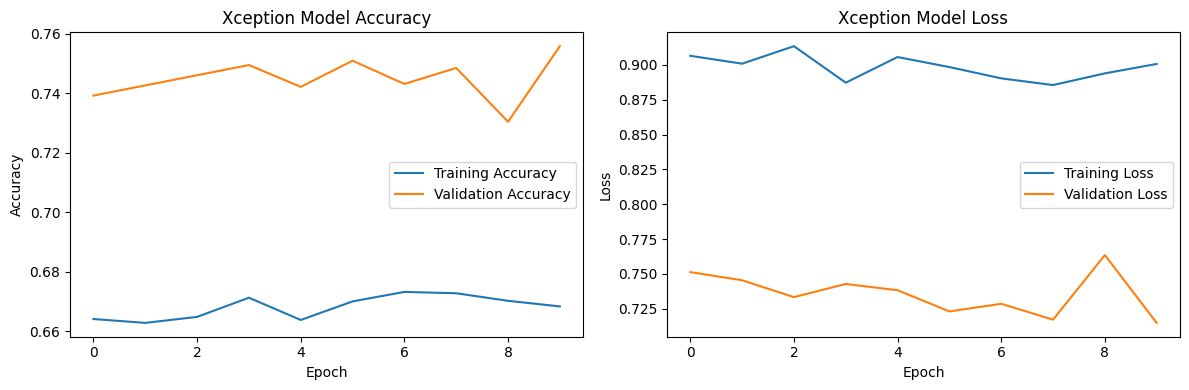


Final Training Accuracy: 0.6684
Final Validation Accuracy: 0.7559
Final Training Loss: 0.9006
Final Validation Loss: 0.7149

Best model saved at: /Users/vigneshs/Desktop/Neem_leaf_project/models/xception_best_model.keras
Training completed!


In [8]:
BATCH_SIZE = 16
EPOCHS = 10
MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/models/xception_best_model.keras"
CHECKPOINT_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/models/xception_training_checkpoint.weights.h5"
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Create models directory
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Load val_df
if not os.path.exists(VAL_DF_PATH):
    raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please run Step 7 first.")
val_df = pd.read_csv(VAL_DF_PATH)

# Verify augmented_df
if 'augmented_df' not in globals():
    raise NameError("augmented_df not found. Please run Step 6 first.")

# Define generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=augmented_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Custom callback for 2-minute rest
class RestCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nResting for 2 minutes after epoch {epoch + 1}...")
        time.sleep(120)
        print("Rest complete, resuming training...")

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    ),
    RestCallback()
]

# Check for checkpoint
initial_epoch = 0
if os.path.exists(CHECKPOINT_PATH):
    xception_model.load_weights(CHECKPOINT_PATH)
    print(f"Resuming training from checkpoint at {CHECKPOINT_PATH}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Train the model
history = xception_model.fit(
    train_generator,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"\nBest model saved at: {MODEL_SAVE_PATH}")
print(f"Training completed!")

Save Xeption 

In [ ]:

MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/xception_trained_model.keras"

# Ensure the models directory exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Save the trained model
xception_model.save(MODEL_SAVE_PATH)

# Confirm the model is saved
print(f"Xception model saved successfully to '{MODEL_SAVE_PATH}'!")

Xception model saved successfully to '/Users/vigneshs/Desktop/Neem_leaf_project/model_final/xception_trained_model.keras'!


Build ResNet50 Model

In [13]:
# Step 10: Build ResNet50 Model
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import pandas as pd
import os

# Define constants
IMG_SIZE_RESNET = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7
BASE_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project/new_neem_dataset"
CLASS_NAMES = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Recreate datasets with ResNet50 input size (224, 224)
def create_datasets():
    global train_dataset_aug, validation_dataset, augmented_df, val_df
    
    def load_image(filename, label):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE_RESNET)
        image = tf.keras.applications.resnet50.preprocess_input(image)
        return image, label
    
    # Verify augmented_df exists (from Step 6)
    if 'augmented_df' not in globals():
        raise NameError("augmented_df not found. Please run Step 6 first.")
    
    # Update train_dataset_aug (15,372 images)
    class_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in augmented_df['class']],
        num_classes=NUM_CLASSES
    )
    labels = tf.cast(labels, tf.float32)
    
    train_dataset_aug = tf.data.Dataset.from_tensor_slices((augmented_df['filename'].values, labels))
    train_dataset_aug = train_dataset_aug.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset_aug = train_dataset_aug.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    
    # Load validation dataset (~2,048 images, original data)
    if not os.path.exists(VAL_DF_PATH):
        raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please run Step 7.")
    val_df = pd.read_csv(VAL_DF_PATH)
    
    val_labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in val_df['class']],
        num_classes=NUM_CLASSES
    )
    val_labels = tf.cast(val_labels, tf.float32)  # Fixed: Use val_labels, not labels
    
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['filename'].values, val_labels))
    validation_dataset = validation_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    
    return len(augmented_df), len(val_df), val_df

# Build ResNet50 model (using your provided architecture)
def build_resnet50_model():
    input_shape = (IMG_SIZE_RESNET[0], IMG_SIZE_RESNET[1], 3)
    
    # Load pre-trained ResNet50
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers with ResNet50 preprocessing
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    resnet50_model = tf.keras.Model(inputs, outputs, name='ResNet50_Model')
    
    # Compile the model
    resnet50_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return resnet50_model

# Execute Step 10
try:
    train_size, val_size, val_df = create_datasets()
    print(f"Updated datasets for ResNet50 (224x224):")
    print(f"Training dataset: ~{train_size} images")
    print(f"Validation dataset: ~{val_size} images")
    
    # Check validation class distribution
    val_class_counts = val_df['class'].value_counts()
    print("\nValidation class distribution:")
    print(val_class_counts)
    
    resnet50_model = build_resnet50_model()
    resnet50_model.summary()
    
    # Verify datasets
    for images, labels in train_dataset_aug.take(1):
        print(f"Training batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")
    
    for images, labels in validation_dataset.take(1):
        print(f"Validation batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")
    
    print("\nResNet50 model built and compiled successfully!")
except Exception as e:
    print(f"Error in Step 10: {e}")
    raise

Updated datasets for ResNet50 (224x224):
Training dataset: ~15372 images
Validation dataset: ~2048 images

Validation class distribution:
class
Healthy           511
Powdery_Mildew    410
Leaf_Blight       312
Leaf_Miners       262
Leaf_Rust         189
Dieback           182
Alternaria        182
Name: count, dtype: int64


Model: "ResNet50_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_12[0][0]      │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │     14,343 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training batch - Images shape: (16, 224, 224, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>
Validation batch - Images shape: (16, 224, 224, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>

ResNet50 model built and compiled successfully!


2025-04-13 14:09:16.979547: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Train ResNet50 Model

Found 15372 validated image filenames belonging to 7 classes.
Found 2048 validated image filenames belonging to 7 classes.
Class weights: {0: np.float64(1.6075353218210362), 1: np.float64(1.6075353218210362), 2: np.float64(0.5725468269499581), 3: np.float64(0.9377289377289377), 4: np.float64(1.1166848418756816), 5: np.float64(1.5479969765684052), 6: np.float64(0.713588850174216)}


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5291 - loss: 1.2684
Epoch 1: val_accuracy improved from -inf to 0.68994, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_trained_model.keras

Epoch 1: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_checkpoint.weights.h5

Resting for 2 minutes after epoch 1...
Rest complete, resuming training...
961/961 ━━━━━━━━━━━━━━━━━━━━ 676s 700ms/step - accuracy: 0.5291 - loss: 1.2682 - val_accuracy: 0.6899 - val_loss: 0.8400
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6797 - loss: 0.8440
Epoch 2: val_accuracy improved from 0.68994 to 0.69629, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_trained_model.keras

Epoch 2: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_checkpoint.weights.h5

Resting for 2 minutes after epoch 2...
Rest complete, resuming training...
961/961 ━━━━━━━━━━━━━━

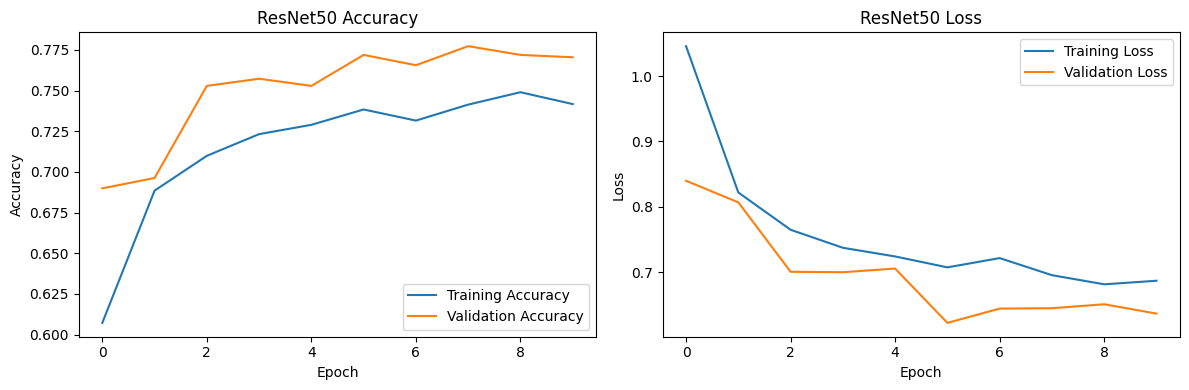


Final Training Accuracy: 0.7417
Final Validation Accuracy: 0.7705
Final Training Loss: 0.6874
Final Validation Loss: 0.6372

Best model saved at: /Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_trained_model.keras
ResNet50 training completed!


In [15]:
BATCH_SIZE = 16
EPOCHS = 10
IMG_SIZE_RESNET = (224, 224)
NUM_CLASSES = 7
MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_trained_model.keras"
CHECKPOINT_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_checkpoint.weights.h5"
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Create models directory
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Load val_df
if not os.path.exists(VAL_DF_PATH):
    raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please run Step 7.")
val_df = pd.read_csv(VAL_DF_PATH)

# Verify augmented_df
if 'augmented_df' not in globals():
    raise NameError("augmented_df not found. Please run Step 6.")

# Define generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=augmented_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_RESNET,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_RESNET,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights for imbalanced validation
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(val_df['class']),
    y=val_df['class']
)
class_weights_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}
print("Class weights:", class_weights_dict)

# Custom callback for 2-minute rest
class RestCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nResting for 2 minutes after epoch {epoch + 1}...")
        time.sleep(120)
        print("Rest complete, resuming training...")

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    ),
    RestCallback()
]

# Train the model (assumes resnet50_model from Step 10)
try:
    history = resnet50_model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )
except NameError:
    raise NameError("resnet50_model not found. Please run Step 10 first.")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"\nBest model saved at: {MODEL_SAVE_PATH}")
print("ResNet50 training completed!")

Save ResNet50 Model

In [ ]:
MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_trained_model.keras"
# Ensure the models directory exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
# Save the trained model
resnet50_model.save(MODEL_SAVE_PATH)
# Confirm the model is saved
print(f"ResNet50 model saved successfully to '{MODEL_SAVE_PATH}'!")

ResNet50 model saved successfully to '/Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_trained_model.keras'!


Build EfficientNetV2B0 Model

In [7]:
IMG_SIZE_EFFNET = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7
BASE_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project/new_neem_dataset"
CLASS_NAMES = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Recreate datasets with EfficientNetV2B0 input size (224, 224)
def create_datasets():
    global train_dataset_aug, validation_dataset, augmented_df, val_df
    
    def load_image(filename, label):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE_EFFNET)
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
        return image, label
    
    # Verify augmented_df exists (from Step 6)
    if 'augmented_df' not in globals():
        raise NameError("augmented_df not found. Please run Step 6 first.")
    
    # Update train_dataset_aug (15,372 images)
    class_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in augmented_df['class']],
        num_classes=NUM_CLASSES
    )
    labels = tf.cast(labels, tf.float32)
    
    train_dataset_aug = tf.data.Dataset.from_tensor_slices((augmented_df['filename'].values, labels))
    train_dataset_aug = train_dataset_aug.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset_aug = train_dataset_aug.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    
    # Load validation dataset (~2,048 images, original data)
    if not os.path.exists(VAL_DF_PATH):
        raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please run Step 7.")
    val_df = pd.read_csv(VAL_DF_PATH)
    
    val_labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in val_df['class']],
        num_classes=NUM_CLASSES
    )
    val_labels = tf.cast(val_labels, tf.float32)
    
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['filename'].values, val_labels))
    validation_dataset = validation_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    
    return len(augmented_df), len(val_df), val_df

# Build EfficientNetV2B0 model
def build_efficientnetv2b0_model():
    input_shape = (IMG_SIZE_EFFNET[0], IMG_SIZE_EFFNET[1], 3)
    
    # Load pre-trained EfficientNetV2B0
    base_model = tf.keras.applications.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers with EfficientNetV2 preprocessing
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    efficientnetv2b0_model = tf.keras.Model(inputs, outputs, name='EfficientNetV2B0_Model')
    
    # Compile the model
    efficientnetv2b0_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return efficientnetv2b0_model

# Execute Step 13
try:
    train_size, val_size, val_df = create_datasets()
    print(f"Updated datasets for EfficientNetV2B0 (224x224):")
    print(f"Training dataset: ~{train_size} images")
    print(f"Validation dataset: ~{val_size} images")
    
    # Check validation class distribution
    val_class_counts = val_df['class'].value_counts()
    print("\nValidation class distribution:")
    print(val_class_counts)
    
    efficientnetv2b0_model = build_efficientnetv2b0_model()
    efficientnetv2b0_model.summary()
    
    # Verify datasets
    for images, labels in train_dataset_aug.take(1):
        print(f"Training batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")
    
    for images, labels in validation_dataset.take(1):
        print(f"Validation batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")
    
    print("\nEfficientNetV2B0 model built and compiled successfully!")
except Exception as e:
    print(f"Error in Step 13: {e}")
    raise

Updated datasets for EfficientNetV2B0 (224x224):
Training dataset: ~15372 images
Validation dataset: ~2048 images

Validation class distribution:
class
Healthy           511
Powdery_Mildew    410
Leaf_Blight       312
Leaf_Miners       262
Leaf_Rust         189
Dieback           182
Alternaria        182
Name: count, dtype: int64


Model: "EfficientNetV2B0_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Training batch - Images shape: (16, 224, 224, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>
Validation batch - Images shape: (16, 224, 224, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>

EfficientNetV2B0 model built and compiled successfully!


2025-04-13 22:05:43.293995: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-13 22:05:43.297364: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train EfficientNetV2B0 model

Found 15372 validated image filenames belonging to 7 classes.
Found 2048 validated image filenames belonging to 7 classes.
Class weights: {0: np.float64(1.6075353218210362), 1: np.float64(1.6075353218210362), 2: np.float64(0.5725468269499581), 3: np.float64(0.9377289377289377), 4: np.float64(1.1166848418756816), 5: np.float64(1.5479969765684052), 6: np.float64(0.713588850174216)}


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4938 - loss: 1.3210
Epoch 1: val_accuracy improved from -inf to 0.69580, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_trained_model.keras

Epoch 1: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_checkpoint.weights.h5

Resting for 2 minutes after epoch 1...
Rest complete, resuming training...
961/961 ━━━━━━━━━━━━━━━━━━━━ 296s 304ms/step - accuracy: 0.4939 - loss: 1.3208 - val_accuracy: 0.6958 - val_loss: 0.8905
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6656 - loss: 0.8839
Epoch 2: val_accuracy improved from 0.69580 to 0.74219, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_trained_model.keras

Epoch 2: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_checkpoint.weights.h5

Resting for 2 minutes after epoch 2...
Rest complete, resuming tr

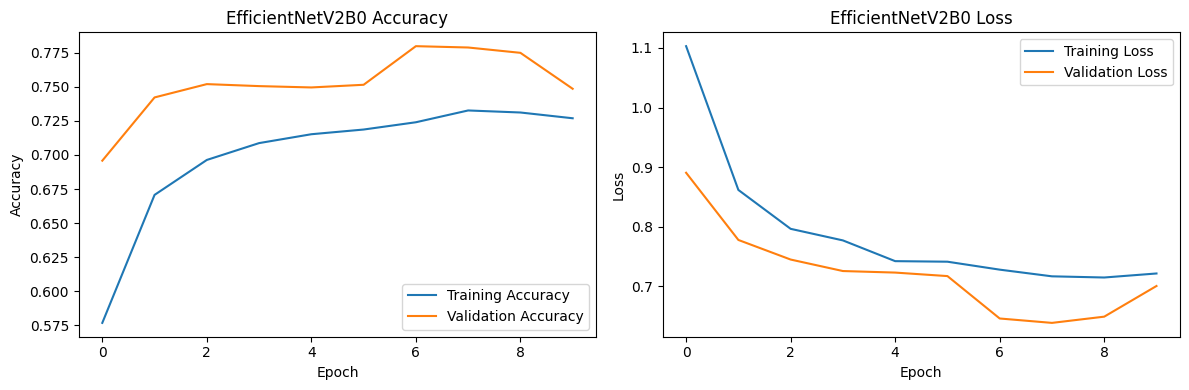


Final Training Accuracy: 0.7269
Final Validation Accuracy: 0.7485
Final Training Loss: 0.7215
Final Validation Loss: 0.7005

Best model saved at: /Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_trained_model.keras
EfficientNetV2B0 training completed!


In [8]:
BATCH_SIZE = 16
EPOCHS = 10
IMG_SIZE_EFFNET = (224, 224)
NUM_CLASSES = 7
MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_trained_model.keras"
CHECKPOINT_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_checkpoint.weights.h5"
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Create models directory
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Load val_df
if not os.path.exists(VAL_DF_PATH):
    raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please run Step 7.")
val_df = pd.read_csv(VAL_DF_PATH)

# Verify augmented_df
if 'augmented_df' not in globals():
    raise NameError("augmented_df not found. Please run Step 6.")

# Define generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=augmented_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_EFFNET,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_EFFNET,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights for imbalanced validation
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(val_df['class']),
    y=val_df['class']
)
class_weights_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}
print("Class weights:", class_weights_dict)

# Custom callback for 2-minute rest
class RestCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nResting for 2 minutes after epoch {epoch + 1}...")
        time.sleep(120)
        print("Rest complete, resuming training...")

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    ),
    RestCallback()
]

# Train the model (assumes efficientnetv2b0_model from Step 13)
try:
    history = efficientnetv2b0_model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )
except NameError:
    raise NameError("efficientnetv2b0_model not found. Please run Step 13 first.")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetV2B0 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetV2B0 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"\nBest model saved at: {MODEL_SAVE_PATH}")
print("EfficientNetV2B0 training completed!")

Save EfficientNetV2B0 Model

In [9]:
MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_trained_model.keras"
# Ensure the models directory exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
# Save the trained model
efficientnetv2b0_model.save(MODEL_SAVE_PATH)
# Confirm the model is saved
print(f"EfficientNetV2B0 model saved successfully to '{MODEL_SAVE_PATH}'!")

EfficientNetV2B0 model saved successfully to '/Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_trained_model.keras'!


Build custom EfficientNetV2B0 model 

In [10]:
IMG_SIZE_EFFNET = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7
BASE_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project/new_neem_dataset"
CLASS_NAMES = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Recreate datasets with EfficientNetV2 input size (224, 224)
def create_datasets():
    global train_dataset_aug, validation_dataset, augmented_df, val_df
    
    def load_image(filename, label):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE_EFFNET)
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
        return image, label
    
    # Verify augmented_df exists (from Step 6)
    if 'augmented_df' not in globals():
        raise NameError("augmented_df not found. Please run Step 6 first.")
    
    # Update train_dataset_aug (15,372 images)
    class_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in augmented_df['class']],
        num_classes=NUM_CLASSES
    )
    labels = tf.cast(labels, tf.float32)
    
    train_dataset_aug = tf.data.Dataset.from_tensor_slices((augmented_df['filename'].values, labels))
    train_dataset_aug = train_dataset_aug.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset_aug = train_dataset_aug.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    
    # Load validation dataset (~2,048 images, original data)
    if not os.path.exists(VAL_DF_PATH):
        raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please run Step 7.")
    val_df = pd.read_csv(VAL_DF_PATH)
    
    val_labels = tf.keras.utils.to_categorical(
        [class_to_index[c] for c in val_df['class']],
        num_classes=NUM_CLASSES
    )
    val_labels = tf.cast(val_labels, tf.float32)
    
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['filename'].values, val_labels))
    validation_dataset = validation_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    
    return len(augmented_df), len(val_df), val_df

# Build custom EfficientNetV2B0 model
def build_custom_efficientnetv2b0_model():
    input_shape = (IMG_SIZE_EFFNET[0], IMG_SIZE_EFFNET[1], 3)
    
    # Load pre-trained EfficientNetV2B0
    base_model = tf.keras.applications.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )
    
    # Fine-tune: Freeze all layers initially
    base_model.trainable = True
    
    # Unfreeze top ~20% layers (~40 layers, ~1M params)
    total_layers = len(base_model.layers)
    fine_tune_at = int(total_layers * 0.8)  # Start fine-tuning at ~80% mark
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Verify fine-tuned layers
    trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
    print(f"Total layers: {total_layers}, Fine-tuned layers: {trainable_layers}")
    
    # Build custom head
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)  # Use training=False for BN during inference
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    custom_efficientnetv2b0_model = tf.keras.Model(inputs, outputs, name='Custom_EfficientNetV2B0_Model')
    
    # Compile with lower learning rate for fine-tuning
    custom_efficientnetv2b0_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return custom_efficientnetv2b0_model

# Execute Step 16
try:
    train_size, val_size, val_df = create_datasets()
    print(f"Updated datasets for Custom EfficientNetV2B0 (224x224):")
    print(f"Training dataset: ~{train_size} images")
    print(f"Validation dataset: ~{val_size} images")
    
    # Check validation class distribution
    val_class_counts = val_df['class'].value_counts()
    print("\nValidation class distribution:")
    print(val_class_counts)
    
    custom_efficientnetv2b0_model = build_custom_efficientnetv2b0_model()
    custom_efficientnetv2b0_model.summary()
    
    # Verify datasets
    for images, labels in train_dataset_aug.take(1):
        print(f"Training batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")
    
    for images, labels in validation_dataset.take(1):
        print(f"Validation batch - Images shape: {images.shape}, Labels shape: {labels.shape}, Labels dtype: {labels.dtype}")
    
    print("\nCustom EfficientNetV2B0 model built and compiled successfully!")
except Exception as e:
    print(f"Error in Step 16: {e}")
    raise

Updated datasets for Custom EfficientNetV2B0 (224x224):
Training dataset: ~15372 images
Validation dataset: ~2048 images

Validation class distribution:
class
Healthy           511
Powdery_Mildew    410
Leaf_Blight       312
Leaf_Miners       262
Leaf_Rust         189
Dieback           182
Alternaria        182
Name: count, dtype: int64
Total layers: 270, Fine-tuned layers: 54


Model: "Custom_EfficientNetV2B0_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,250,071 (23.84 MB)

 Trainable params: 2,565,143 (9.79 MB)

 Non-trainable params: 3,684,928 (14.06 MB)

Training batch - Images shape: (16, 224, 224, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>
Validation batch - Images shape: (16, 224, 224, 3), Labels shape: (16, 7), Labels dtype: <dtype: 'float32'>

Custom EfficientNetV2B0 model built and compiled successfully!


2025-04-13 23:05:29.681227: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Train Custom EfficientNetV2B0 Model

Found 15372 validated image filenames belonging to 7 classes.
Found 2048 validated image filenames belonging to 7 classes.
Class weights: {0: np.float64(1.6075353218210362), 1: np.float64(1.6075353218210362), 2: np.float64(0.5725468269499581), 3: np.float64(0.9377289377289377), 4: np.float64(1.1166848418756816), 5: np.float64(1.5479969765684052), 6: np.float64(0.713588850174216)}


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4968 - loss: 1.4784
Epoch 1: val_accuracy improved from -inf to 0.74561, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_trained_model.keras

Epoch 1: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_checkpoint.weights.h5

Resting for 2 minutes after epoch 1...
Rest complete, resuming training...
961/961 ━━━━━━━━━━━━━━━━━━━━ 362s 370ms/step - accuracy: 0.4969 - loss: 1.4781 - val_accuracy: 0.7456 - val_loss: 0.6980
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7158 - loss: 0.7732
Epoch 2: val_accuracy improved from 0.74561 to 0.82129, saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_trained_model.keras

Epoch 2: saving model to /Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_checkpoint.weights.h5

Resting for 2 minutes after epoch 2..

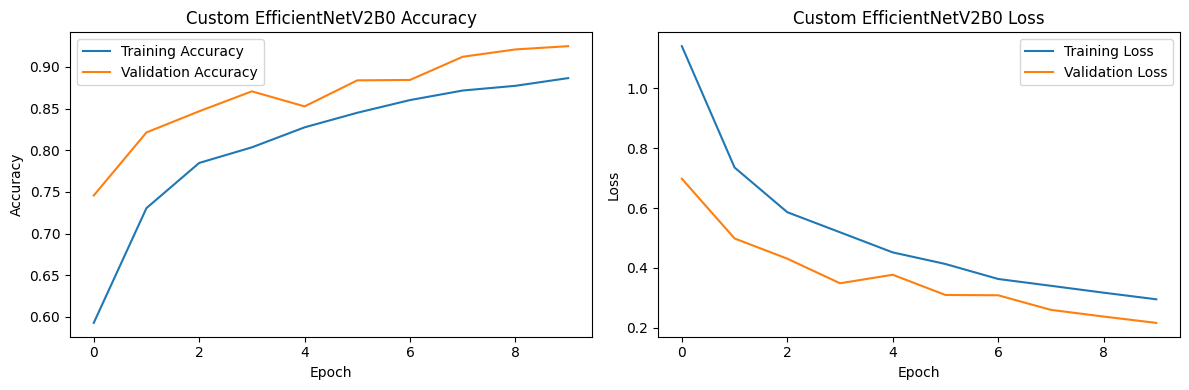


Final Training Accuracy: 0.8865
Final Validation Accuracy: 0.9248
Final Training Loss: 0.2955
Final Validation Loss: 0.2167

Best model saved at: /Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_trained_model.keras
Custom EfficientNetV2B0 training completed!


In [11]:
BATCH_SIZE = 16
EPOCHS = 10
IMG_SIZE_EFFNET = (224, 224)
NUM_CLASSES = 7
MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_trained_model.keras"
CHECKPOINT_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_checkpoint.weights.h5"
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"

# Create models directory
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Load val_df
if not os.path.exists(VAL_DF_PATH):
    raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please run Step 7.")
val_df = pd.read_csv(VAL_DF_PATH)

# Verify augmented_df
if 'augmented_df' not in globals():
    raise NameError("augmented_df not found. Please run Step 6.")

# Define generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=augmented_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_EFFNET,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_EFFNET,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights for imbalanced validation
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(val_df['class']),
    y=val_df['class']
)
class_weights_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}
print("Class weights:", class_weights_dict)

# Custom callback for 2-minute rest
class RestCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nResting for 2 minutes after epoch {epoch + 1}...")
        time.sleep(120)
        print("Rest complete, resuming training...")

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    ),
    RestCallback()
]

# Train the model (assumes custom_efficientnetv2b0_model from Step 16)
try:
    history = custom_efficientnetv2b0_model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )
except NameError:
    raise NameError("custom_efficientnetv2b0_model not found. Please run Step 16 first.")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom EfficientNetV2B0 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Custom EfficientNetV2B0 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"\nBest model saved at: {MODEL_SAVE_PATH}")
print("Custom EfficientNetV2B0 training completed!")

Save Custom EfficientNetV2B0 Model

In [12]:
MODEL_SAVE_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_trained_model.keras"
# Ensure the models directory exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
# Save the trained model
custom_efficientnetv2b0_model.save(MODEL_SAVE_PATH)
# Confirm the model is saved
print(f"Custom EfficientNetV2B0 model saved successfully to '{MODEL_SAVE_PATH}'!")

Custom EfficientNetV2B0 model saved successfully to '/Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_trained_model.keras'!


Evaluate all models on test set 


Evaluating Xception...
Found 2046 validated image filenames belonging to 7 classes.
Found 2045 validated image filenames belonging to 7 classes.


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7280 - loss: 0.7660
128/128 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step

Classification report for Xception:
                precision    recall  f1-score   support

    Alternaria       0.70      0.74      0.72       199
       Dieback       0.98      0.99      0.98       180
   Leaf_Blight       0.75      0.84      0.79       472
   Leaf_Miners       0.73      0.70      0.72       349
     Leaf_Rust       0.79      0.63      0.70       260
Powdery_Mildew       0.65      0.58      0.61       185
       Healthy       0.70      0.74      0.72       401

      accuracy                           0.75      2046
     macro avg       0.76      0.75      0.75      2046
  weighted avg       0.75      0.75      0.75      2046


Evaluating ResNet50...
Found 2046 validated image filenames belonging to 7 classes.
Found 2045 validated image filenames belonging to 7 classes.


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 528ms/step - accuracy: 0.7747 - loss: 0.6426
128/128 ━━━━━━━━━━━━━━━━━━━━ 67s 519ms/step

Classification report for ResNet50:
                precision    recall  f1-score   support

    Alternaria       0.82      0.87      0.84       199
       Dieback       1.00      1.00      1.00       180
   Leaf_Blight       0.88      0.72      0.79       472
   Leaf_Miners       0.75      0.82      0.79       349
     Leaf_Rust       0.71      0.70      0.71       260
Powdery_Mildew       0.56      0.80      0.66       185
       Healthy       0.82      0.74      0.78       401

      accuracy                           0.79      2046
     macro avg       0.79      0.81      0.80      2046
  weighted avg       0.80      0.79      0.79      2046


Evaluating EfficientNetV2B0...
Found 2046 validated image filenames belonging to 7 classes.
Found 2045 validated image filenames belonging to 7 classes.


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.7517 - loss: 0.6887
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step

Classification report for EfficientNetV2B0:
                precision    recall  f1-score   support

    Alternaria       0.85      0.83      0.84       199
       Dieback       1.00      1.00      1.00       180
   Leaf_Blight       0.79      0.81      0.80       472
   Leaf_Miners       0.73      0.71      0.72       349
     Leaf_Rust       0.79      0.58      0.67       260
Powdery_Mildew       0.56      0.76      0.64       185
       Healthy       0.70      0.70      0.70       401

      accuracy                           0.76      2046
     macro avg       0.77      0.77      0.77      2046
  weighted avg       0.76      0.76      0.76      2046


Evaluating Custom EfficientNetV2B0...
Found 2046 validated image filenames belonging to 7 classes.
Found 2045 validated image filenames belonging to 7 classes.


/Users/vigneshs/Desktop/Neem_leaf_project/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9226 - loss: 0.2034
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step

Classification report for Custom EfficientNetV2B0:
                precision    recall  f1-score   support

    Alternaria       0.97      0.95      0.96       199
       Dieback       1.00      1.00      1.00       180
   Leaf_Blight       0.93      0.96      0.95       472
   Leaf_Miners       0.95      0.84      0.89       349
     Leaf_Rust       0.91      0.95      0.93       260
Powdery_Mildew       0.90      0.86      0.88       185
       Healthy       0.87      0.93      0.90       401

      accuracy                           0.93      2046
     macro avg       0.93      0.93      0.93      2046
  weighted avg       0.93      0.93      0.93      2046


Best model (Custom EfficientNetV2B0, Test Accuracy: 0.9262) saved to: /Users/vigneshs/Desktop/Neem_leaf_project/model_final/best_model.keras

Evaluation Results Table:
                  Model  Precision   R

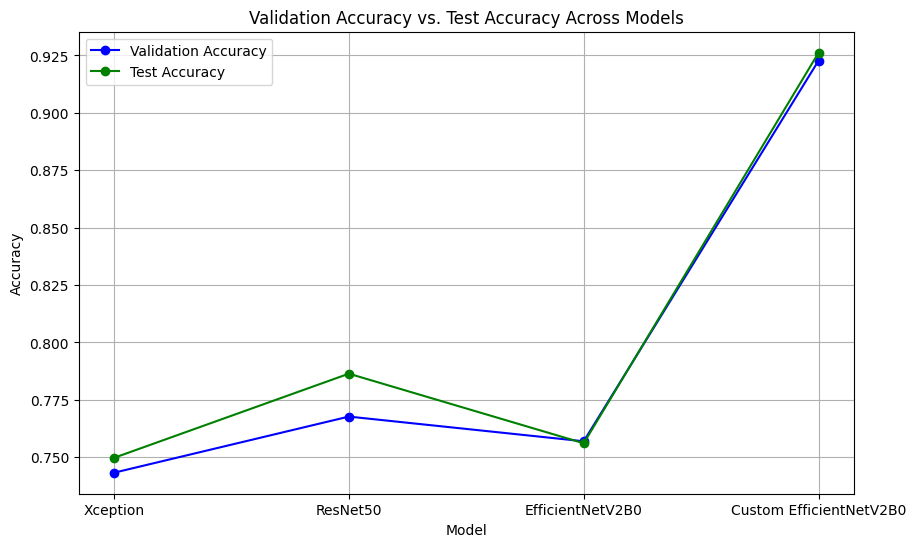


Line plot saved to: /Users/vigneshs/Desktop/Neem_leaf_project/model_final/accuracy_line_plot.png


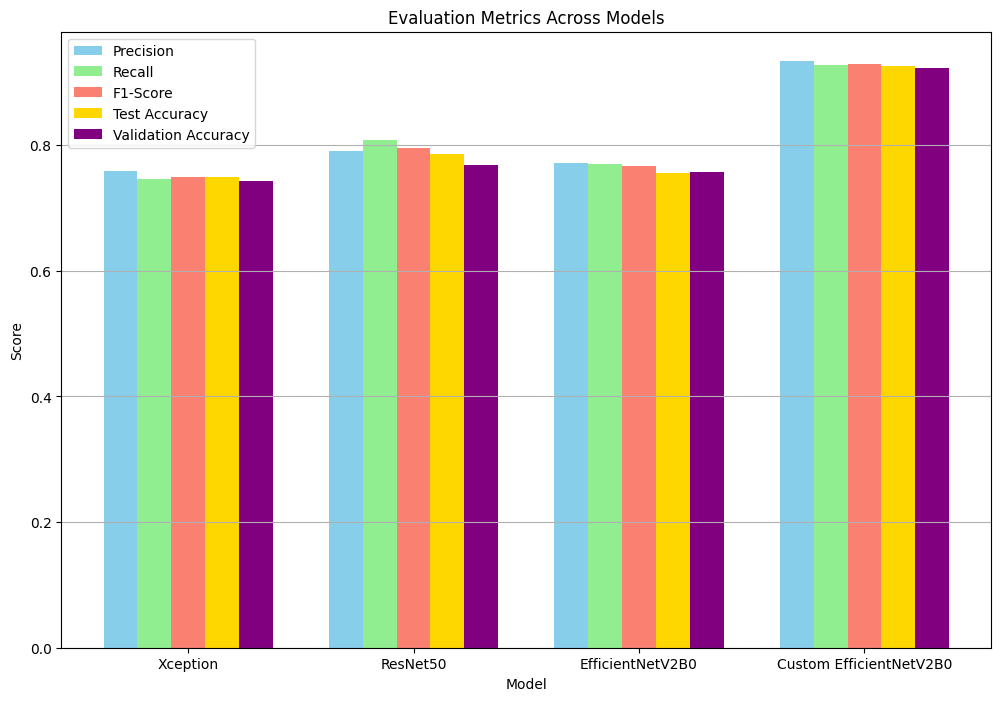


Bar plot saved to: /Users/vigneshs/Desktop/Neem_leaf_project/model_final/metrics_bar_plot.png
Model evaluation completed!


In [25]:
BATCH_SIZE = 16
NUM_CLASSES = 7
TEST_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/test_df.csv"
VAL_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/val_df.csv"
BEST_MODEL_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/best_model.keras"
CLASS_NAMES = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
MODEL_PATHS = {
    'Xception': {
        'path': "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/xception_trained_model.keras",
        'img_size': (299, 299)
    },
    'ResNet50': {
        'path': "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/resnet50_trained_model.keras",
        'img_size': (224, 224)
    },
    'EfficientNetV2B0': {
        'path': "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/efficientnetv2b0_trained_model.keras",
        'img_size': (224, 224)
    },
    'Custom EfficientNetV2B0': {
        'path': "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/custom_efficientnetv2b0_trained_model.keras",
        'img_size': (224, 224)
    }
}
OUTPUT_DIR = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load test and validation datasets
if not os.path.exists(TEST_DF_PATH):
    raise FileNotFoundError(f"test_df not found at {TEST_DF_PATH}. Please ensure Step 7 created it.")
test_df = pd.read_csv(TEST_DF_PATH)

if not os.path.exists(VAL_DF_PATH):
    raise FileNotFoundError(f"val_df not found at {VAL_DF_PATH}. Please ensure Step 7 created it.")
val_df = pd.read_csv(VAL_DF_PATH)

# Initialize results
results = []
best_accuracy = 0.0
best_model = None
best_model_name = None

# Evaluate each model
for model_name, model_info in MODEL_PATHS.items():
    print(f"\nEvaluating {model_name}...")
    img_size = model_info['img_size']
    model_path = model_info['path']
    
    # Define generators for this model’s input size
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    val_datagen = ImageDataGenerator()
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Load model
    try:
        model = load_model(model_path)
    except Exception as e:
        raise FileNotFoundError(f"Failed to load {model_name} at {model_path}: {e}")
    
    # Compute validation accuracy
    val_generator.reset()
    val_metrics = model.evaluate(val_generator, verbose=1)
    val_accuracy = val_metrics[1]  # Accuracy is typically the second metric after loss
    
    # Predict on test set
    test_generator.reset()
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Compute test metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
    accuracy = accuracy_score(y_true, y_pred_classes)
    
    # Store results
    results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'Validation Accuracy': val_accuracy
    })
    
    # Track best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = model_name
    
    # Print per-class metrics for Leaf_Rust/Leaf_Miners
    print(f"\nClassification report for {model_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))
    
    # Clean up
    del model
    tf.keras.backend.clear_session()

# Save best model
if best_model is not None:
    best_model.save(BEST_MODEL_PATH)
    print(f"\nBest model ({best_model_name}, Test Accuracy: {best_accuracy:.4f}) saved to: {BEST_MODEL_PATH}")

# Create results table
results_df = pd.DataFrame(results)
print("\nEvaluation Results Table:")
print(results_df.to_string(index=False))

# Save table
table_path = os.path.join(OUTPUT_DIR, "evaluation_results.csv")
results_df.to_csv(table_path, index=False)
print(f"\nTable saved to: {table_path}")

# Line graph: Validation Accuracy vs. Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(results_df['Model'], results_df['Validation Accuracy'], marker='o', label='Validation Accuracy', color='blue')
plt.plot(results_df['Model'], results_df['Accuracy'], marker='o', label='Test Accuracy', color='green')
plt.title('Validation Accuracy vs. Test Accuracy Across Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
line_plot_path = os.path.join(OUTPUT_DIR, "accuracy_line_plot.png")
plt.savefig(line_plot_path)
plt.show()
print(f"\nLine plot saved to: {line_plot_path}")

# Bar graph: Precision, Recall, F1-Score, Accuracy, Validation Accuracy
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Validation Accuracy']
x = np.arange(len(MODEL_PATHS))
width = 0.15

plt.figure(figsize=(12, 8))
plt.bar(x - 2*width, results_df['Precision'], width, label='Precision', color='skyblue')
plt.bar(x - width, results_df['Recall'], width, label='Recall', color='lightgreen')
plt.bar(x, results_df['F1-Score'], width, label='F1-Score', color='salmon')
plt.bar(x + width, results_df['Accuracy'], width, label='Test Accuracy', color='gold')
plt.bar(x + 2*width, results_df['Validation Accuracy'], width, label='Validation Accuracy', color='purple')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Evaluation Metrics Across Models')
plt.xticks(x, results_df['Model'])
plt.legend()
plt.grid(True, axis='y')
bar_plot_path = os.path.join(OUTPUT_DIR, "metrics_bar_plot.png")
plt.savefig(bar_plot_path)
plt.show()
print(f"\nBar plot saved to: {bar_plot_path}")

print("Model evaluation completed!")

Preection

In [ ]:
IMG_SIZE = (224, 224)
BEST_MODEL_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/model_final/best_model.keras"
TRAIN_DF_PATH = "/Users/vigneshs/Desktop/Neem_leaf_project/train_df.csv"

# Load class labels from train_df.csv
try:
    train_df = pd.read_csv(TRAIN_DF_PATH)
    class_labels = sorted(train_df['class'].unique())
except Exception as e:
    raise FileNotFoundError(f"Failed to load train_df at {TRAIN_DF_PATH}: {e}")

# Verify expected classes
expected_classes = ['Alternaria', 'Dieback', 'Leaf_Blight', 'Leaf_Miners', 'Leaf_Rust', 'Powdery_Mildew', 'Healthy']
if set(class_labels) != set(expected_classes):
    print(f"Warning: Class labels {class_labels} differ from expected {expected_classes}")

# Load best model
try:
    best_model = load_model(BEST_MODEL_PATH)
except Exception as e:
    raise FileNotFoundError(f"Failed to load best model at {BEST_MODEL_PATH}: {e}")

# Prediction function
def predict_neem_disease(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Load and preprocess image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)  
    
    # Predict
    predictions = best_model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    
    return predicted_class, confidence

# Get image path from user
image_path = "/Users/vigneshs/Desktop/Neem_leaf_project/predect/Healthy/Healthy33.jpg"

# Predict and display result
try:
    predicted_class, confidence = predict_neem_disease(image_path)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")
except Exception as e:
    print(f"Error predicting {image_path}: {e}")



Predicted Class: Healthy, Confidence: 84.32%
